In [0]:
# -*- coding: utf-8 -*-

"""
NEURAL NETWORKS AND DEEP LEARNING

ICT FOR LIFE AND HEALTH - Department of Information Engineering
PHYSICS OF DATA - Department of Physics and Astronomy
COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY - Department of Psychology

A.A. 2019/20 (6 CFU)
Dr. Alberto Testolin, Dr. Federico Chiariotti

Author: Dr. Matteo Gadaleta

Lab. 03 - Introduction to PyTorch (part 2)
 
"""

In [0]:
#install the library if it is not already present!!!
pip install -U skorch

     |████████████████████████████████| 102kB 6.3MB/s 


In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

from skorch import NeuralNetClassifier
from scipy.stats import randint
from scipy.stats import uniform

np.random.seed(1)





In [0]:
#%% Operations on GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Importing data

In [0]:
matdata= sio.loadmat('MNIST.mat')

In [0]:
X=[]
Y=[]
for i in range(matdata['input_images'].shape[0]):
  X.append([item for item in matdata['input_images'][i,:]])
  Y.append([item for item in matdata['output_labels'][i]])

Y = [item for sublist in Y for item in sublist]
x = np.asfarray(X )
y= np.asarray(Y, dtype='int')
x = x.astype(np.float32)
y = y.astype(np.int64)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=10/60, random_state=1)


In [0]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

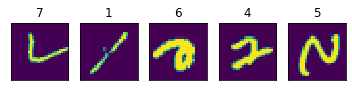

In [86]:
plot_example(x_train, y_train)


In [0]:
x_trainloader = torch.utils.data.DataLoader(x_train, batch_size=5000, shuffle=False)
y_trainloader = torch.utils.data.DataLoader(y_train, batch_size=5000, shuffle=False)
#testloader = torch.utils.data.DataLoader(x_test, batch_size=64, shuffle=False)


In [88]:
x_dataiter = iter(x_trainloader)
y_dataiter = iter(y_trainloader)
images= x_dataiter.next()
labels = y_dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([5000, 784])
torch.Size([5000])


# Defininig class

In [0]:
#%% Neural Network

### Define the network class
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        super().__init__()
        
        #self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, No)
        
        self.act = nn.ReLU()
        
    def forward(self, x, additional_out=False):
        
        x = self.act(self.fc1(x))
        #x = self.dropout(x)
        x = self.act(self.fc2(x))
        #x = self.dropout(x)
        out = self.fc3(x)
        
        if additional_out:
            return out, x
        
        return out






# Training 1 model

In [0]:
Ni = 784
Nh1 = 24
Nh2 = 12
No = 10
dropout = 0
model = Net(Ni, Nh1, Nh2, No)#, dropout)

### Define the loss function (the most used are already implemented in pytorch, see the doc!)
loss_fn = nn.CrossEntropyLoss()


### Define an optimizer
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
model.to(device)

### Training
train_loss_log = []
test_loss_log = []
num_epochs = 1000




for num_epoch in range(num_epochs):
    running_loss=0.0
    print('Epoch', num_epoch + 1)

    for input_train, label_train in zip(x_trainloader, y_trainloader):

        # Training
        model.train() # Training mode (e.g. enable dropout)

        optimizer.zero_grad()

        # Eventually clear previous recorded gradients

        #input_train = torch.tensor(x_train).float().view(-1,784).to(device)
        #label_train = torch.tensor(y_train).long().view(-1,1).squeeze(1).to(device)
        #input_train = torch.tensor(x_train).float().to(device)
        #label_train = torch.tensor(y_train).to(device)
        out = model(input_train.to(device))

        # Evaluate loss

        loss = loss_fn(out, label_train.to(device))
        # Backward pass
        loss.backward()
        # Update
        optimizer.step()
        # Print loss
        running_loss += loss.item()


    print('\t Training loss ():', float(running_loss)/len(x_trainloader))
        
    # Validation
    model.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # No need to track the gradients

        input_test = torch.tensor(x_test).float().view(-1,784).to(device)
        label_test = torch.tensor(y_test).long().view(-1,1).squeeze(1).to(device)
        out = model(input_test)
        # Evaluate global loss
        test_loss = loss_fn(out, label_test)
        # Print loss
        print('\t Validation loss:', float(test_loss.data))
    


    # Log
    train_loss_log.append(float(loss.data))
    test_loss_log.append(float(test_loss.data))

    if (test_loss_log[-1]/min(test_loss_log)-1>0.01):
      break


Epoch 1
	 Training loss (): 2.280951237678528
	 Validation loss: 2.2387092113494873
Epoch 2
	 Training loss (): 2.1918524503707886
	 Validation loss: 2.1289846897125244
Epoch 3
	 Training loss (): 2.06709623336792
	 Validation loss: 1.9895232915878296
Epoch 4
	 Training loss (): 1.9167011499404907
	 Validation loss: 1.830467939376831
Epoch 5
	 Training loss (): 1.7525213837623597
	 Validation loss: 1.6627962589263916
Epoch 6
	 Training loss (): 1.5844443559646606
	 Validation loss: 1.4927260875701904
Epoch 7
	 Training loss (): 1.4154287219047545
	 Validation loss: 1.3220641613006592
Epoch 8
	 Training loss (): 1.248606014251709
	 Validation loss: 1.1598559617996216
Epoch 9
	 Training loss (): 1.0937248945236206
	 Validation loss: 1.0159622430801392
Epoch 10
	 Training loss (): 0.9578612565994262
	 Validation loss: 0.8930119872093201
Epoch 11
	 Training loss (): 0.8420855879783631
	 Validation loss: 0.7897251844406128
Epoch 12
	 Training loss (): 0.7458068430423737
	 Validation loss: 0

In [0]:
softmax = nn.functional.softmax(out.cpu(), dim=1).squeeze().numpy()
argmax=np.argmax(softmax, axis=1)
errors = label_test.cpu().numpy()!=argmax
#print('Class probabilities (softmax):\n ', softmax)
#print('Real classes: ', label_test)
#print('Errors: ', errors)
print('mean accuracy',1-errors.mean())

mean accuracy 0.9587


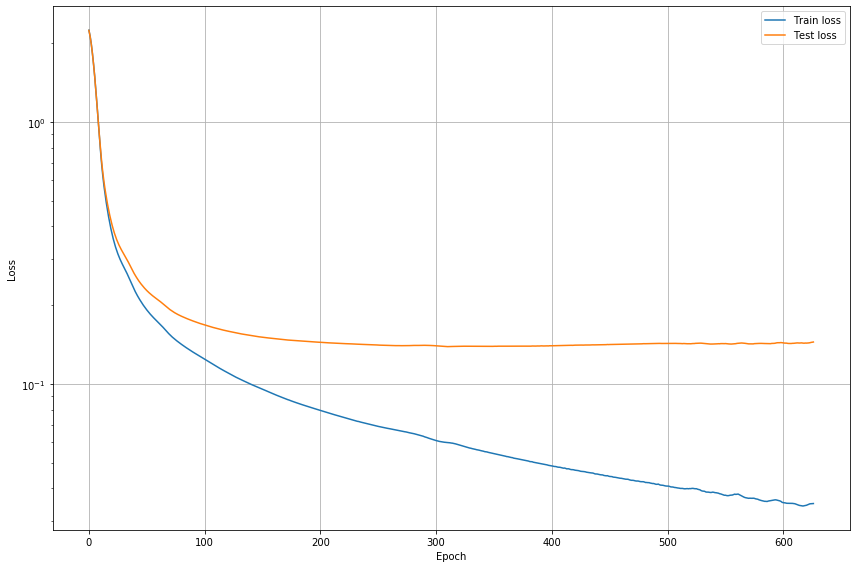

In [0]:
 
# Plot losses
plt.close('all')
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(test_loss_log, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

#print(np.where(errors==1))
#print(np.where(errors==-1))

# RSCV

In [0]:
mask=np.array(np.ones(len(x_train)), 'bool')
x_cv=[]
x_val=[]
y_cv=[]
y_val=[]

for j in range(5):
  temp_mask=mask.copy()
  temp_mask[(j*int(np.round(len(x_train)/5))):((j+1)*int(np.round(len(x_train)/5)))]=False
  x_cv.append(x_train[temp_mask])
  x_val.append(x_train[~temp_mask])
  y_cv.append(y_train[temp_mask])
  y_val.append(y_train[~temp_mask])

x_cv=np.array(x_cv)
x_val=np.array(x_val)
y_cv=np.array(y_cv)
y_val=np.array(y_val)

In [98]:
best_error= np.inf
N=2
num_epochs = 1000
Nh1_list = np.random.randint(100, 500, N)
Nh2_list = np.random.randint(50, 250, N)

### Define the loss function (the most used are already implemented in pytorch, see the doc!)
loss_fn = nn.CrossEntropyLoss()


### Define an optimizer
lr = 1e-3



### Training




for Nh1, Nh2 in zip(Nh1_list, Nh2_list):
    Ni=784
    No=10
    model = Net(Ni, Nh1, Nh2, No)#, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    
    model.to(device)

    print('Nh1', Nh1)
    print('Nh2', Nh2)
    val_loss=0
    stopping_index=0
    c=0

    for xt,yt,xv,yv in zip(x_cv, y_cv, x_val, y_val):
        c+=1
        print(c)
        train_loss_log = []
        val_loss_log = []
        for num_epoch in range(num_epochs):
            running_loss=0.0
            #print('Epoch', num_epoch + 1)

            xt_trainloader = torch.utils.data.DataLoader(xt, batch_size=5000, shuffle=False)
            yt_trainloader = torch.utils.data.DataLoader(yt, batch_size=5000, shuffle=False)

            for input_train, label_train in zip(xt_trainloader, yt_trainloader):

                # Training
                model.train() # Training mode (e.g. enable dropout)

                optimizer.zero_grad()

                # Eventually clear previous recorded gradients

                #input_train = torch.tensor(x_train).float().view(-1,784).to(device)
                #label_train = torch.tensor(y_train).long().view(-1,1).squeeze(1).to(device)
                #input_train = torch.tensor(x_train).float().to(device)
                #label_train = torch.tensor(y_train).to(device)
                out = model(input_train.to(device))

                # Evaluate loss

                loss = loss_fn(out, label_train.to(device))
                # Backward pass
                loss.backward()
                # Update
                optimizer.step()
                # Print loss
                running_loss += loss.item()


            #print('\t Training loss ():', float(running_loss)/len(x_trainloader))
                
            # Validation
            model.eval() # Evaluation mode (e.g. disable dropout)
            with torch.no_grad(): # No need to track the gradients

                input_test = torch.tensor(xv).float().view(-1,784).to(device)
                label_test = torch.tensor(yv).long().view(-1,1).squeeze(1).to(device)
                out = model(input_test)
                # Evaluate global loss
                val_loss_epoch = loss_fn(out, label_test)
                # Print loss
                #print('\t Validation loss:', float(val_loss_epoch.data))
            


            # Log
            train_loss_log.append(float(loss.data))
            val_loss_log.append(float(val_loss_epoch.data))

            if (val_loss_log[-1]/min(val_loss_log)-1>0.01):
              break

        #average error between k-folds
        val_loss+=min(val_loss_log)/len(x_cv)
        if np.argmin(val_loss_log) > stopping_index:
            stopping_index=np.argmin(val_loss_log)

    print('mean validation error',val_loss)
    print('stopping index',stopping_index)

    #assign the best error to the lower value and choosing the parameters using it
    if val_loss < best_error:
          best_error = val_loss
          best_Nh1=Nh1
          best_Nh2=Nh2
          best_epochs = stopping_index

Nh1 366
Nh2 193
1
2
3
4
5
mean validation error 0.05923418253660203
stopping index 45
Nh1 379
Nh2 137
1
2
3
4
5
mean validation error 0.04585087969899177
stopping index 61


In [99]:
Ni = 784
Nh1 = best_Nh1
Nh2 = best_Nh2
No = 10
dropout = 0
model = Net(Ni, Nh1, Nh2, No)#, dropout)

### Define the loss function (the most used are already implemented in pytorch, see the doc!)
loss_fn = nn.CrossEntropyLoss()


### Define an optimizer
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
model.to(device)

### Training
train_loss_log = []
test_loss_log = []
num_epochs = stopping_index




for num_epoch in range(num_epochs):
    running_loss=0.0
    print('Epoch', num_epoch + 1)

    for input_train, label_train in zip(x_trainloader, y_trainloader):

        # Training
        model.train() # Training mode (e.g. enable dropout)

        optimizer.zero_grad()

        # Eventually clear previous recorded gradients

        #input_train = torch.tensor(x_train).float().view(-1,784).to(device)
        #label_train = torch.tensor(y_train).long().view(-1,1).squeeze(1).to(device)
        #input_train = torch.tensor(x_train).float().to(device)
        #label_train = torch.tensor(y_train).to(device)
        out = model(input_train.to(device))

        # Evaluate loss

        loss = loss_fn(out, label_train.to(device))
        # Backward pass
        loss.backward()
        # Update
        optimizer.step()
        # Print loss
        running_loss += loss.item()


    print('\t Training loss ():', float(running_loss)/len(x_trainloader))
        
    # Validation
    model.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # No need to track the gradients

        input_test = torch.tensor(x_test).float().view(-1,784).to(device)
        label_test = torch.tensor(y_test).long().view(-1,1).squeeze(1).to(device)
        out = model(input_test)
        # Evaluate global loss
        test_loss = loss_fn(out, label_test)
        # Print loss
        print('\t Validation loss:', float(test_loss.data))
    


    # Log
    train_loss_log.append(float(loss.data))
    test_loss_log.append(float(test_loss.data))



Epoch 1
	 Training loss (): 1.9184643626213074
	 Validation loss: 1.292710304260254
Epoch 2
	 Training loss (): 0.8778276205062866
	 Validation loss: 0.5582919716835022
Epoch 3
	 Training loss (): 0.4628203004598618
	 Validation loss: 0.40128976106643677
Epoch 4
	 Training loss (): 0.35543390810489656
	 Validation loss: 0.3405354619026184
Epoch 5
	 Training loss (): 0.3071749359369278
	 Validation loss: 0.3081400692462921
Epoch 6
	 Training loss (): 0.2774278402328491
	 Validation loss: 0.28395289182662964
Epoch 7
	 Training loss (): 0.2558500975370407
	 Validation loss: 0.2654557228088379
Epoch 8
	 Training loss (): 0.23798149824142456
	 Validation loss: 0.2484608143568039
Epoch 9
	 Training loss (): 0.2216680258512497
	 Validation loss: 0.23292002081871033
Epoch 10
	 Training loss (): 0.20628214925527572
	 Validation loss: 0.21847395598888397
Epoch 11
	 Training loss (): 0.19202145487070083
	 Validation loss: 0.20544736087322235
Epoch 12
	 Training loss (): 0.17897961735725404
	 Vali

In [100]:
softmax = nn.functional.softmax(out.cpu(), dim=1).squeeze().numpy()
argmax=np.argmax(softmax, axis=1)
errors = label_test.cpu().numpy()!=argmax
#print('Class probabilities (softmax):\n ', softmax)
#print('Real classes: ', label_test)
#print('Errors: ', errors)
print('mean accuracy',1-errors.mean())

mean accuracy 0.9781


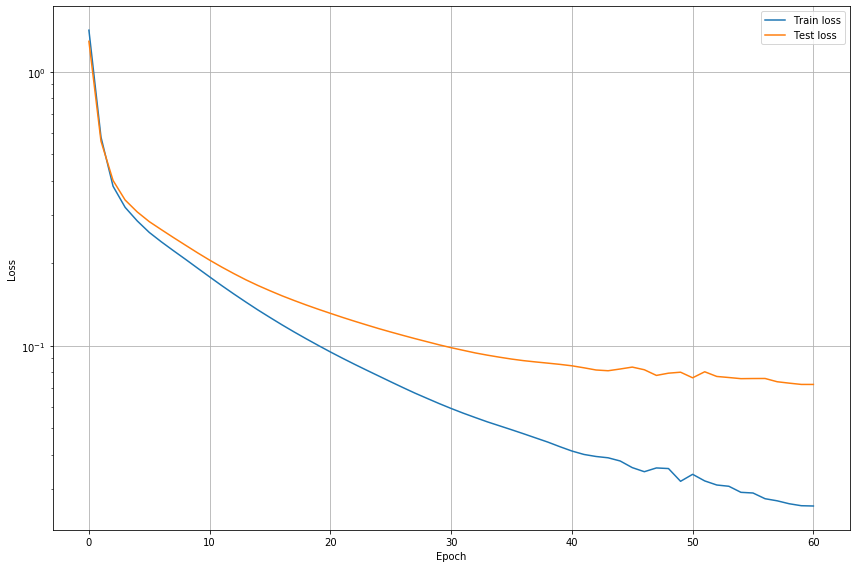

In [101]:
 
# Plot losses
plt.close('all')
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(test_loss_log, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

#print(np.where(errors==1))
#print(np.where(errors==-1))

# SKORCH

In [0]:
#%% Neural Network


### Define the network class
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No, dropout):
        super().__init__()
        
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, No)


    def forward(self, X, **kwargs):
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = F.relu(self.fc2(X))
        X = self.dropout(X)
        X = F.softmax(self.fc3(X), dim=-1)
        #uso la softmax sull'ultimo layer e poi il predict fa una NNLOSS
        return X


In [0]:
from skorch.callbacks import EarlyStopping

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


my_early= EarlyStopping(monitor='valid_loss', patience=3)

net = NeuralNetClassifier(
    module=Net,

    module__dropout=0,
    
    batch_size =5000,
    max_epochs=100,
    verbose = 1,
    
    #callbacks=EarlyStopping,
    lr = 1e-3, 

    optimizer=torch.optim.Adam,
    device=device,
    callbacks=[my_early]

)

#net.fit(x_train, y_train )

In [0]:


hp = {
    'module__Nh1': randint(20, 500),
    'module__Nh2': randint(10, 250)
    #'module__dropout': uniform()
}

# Random search

In [0]:
rscv = RandomizedSearchCV(net, hp, n_iter=1, cv=3,  verbose=1)#, n_jobs=-1 )

In [0]:
net.get_params().keys()

dict_keys(['module', 'criterion', 'optimizer', 'lr', 'max_epochs', 'batch_size', 'iterator_train', 'iterator_valid', 'dataset', 'train_split', 'callbacks', 'warm_start', 'verbose', 'device', 'module__Ni', 'module__Nh1', 'module__Nh2', 'module__No', 'module__dropout', 'history', 'initialized_', 'virtual_params_', 'callbacks_', 'criterion_', 'module_', 'optimizer_', 'callbacks__epoch_timer', 'callbacks__train_loss', 'callbacks__train_loss__scoring', 'callbacks__train_loss__lower_is_better', 'callbacks__train_loss__on_train', 'callbacks__train_loss__name', 'callbacks__train_loss__target_extractor', 'callbacks__train_loss__use_caching', 'callbacks__valid_loss', 'callbacks__valid_loss__scoring', 'callbacks__valid_loss__lower_is_better', 'callbacks__valid_loss__on_train', 'callbacks__valid_loss__name', 'callbacks__valid_loss__target_extractor', 'callbacks__valid_loss__use_caching', 'callbacks__valid_acc', 'callbacks__valid_acc__scoring', 'callbacks__valid_acc__lower_is_better', 'callbacks__v

In [114]:
rscv.fit(x_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2552       0.4212        2.1321  1.3798
      2        2.0385       0.4971        1.8717  0.5450
      3        1.7673       0.5566        1.6008  0.5562
      4        1.4991       0.6337        1.3465  1.3559
      5        1.2519       0.6913        1.1197  0.5396
      6        1.0373       0.7421        0.9293  1.3770
      7        0.8598       0.7829        0.7748  0.5592
      8        0.7170       0.8247        0.6519  1.3681
      9        0.6039       0.8575        0.5561  1.3520
     10        0.5164       0.8727        0.4843  0.5669
     11        0.4514       0.8823        0.4313  0.5485
     12        0.4039       0.8910        0.3922  1.3710
     13        0.3690       0.8973        0.3630  0.5803
     14        0.3424       0.9016        0.3406  1.3626
     15        0.3215       0.9058        0.3228  0.5789
     16        0.3043       0.9

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.7min finished


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2157       0.2588        2.0667  1.6891
      2        1.9257       0.4576        1.7309  1.6347
      3        1.5773       0.6339        1.3744  1.6375
      4        1.2274       0.7278        1.0415  0.8243
      5        0.9250       0.8121        0.7866  1.6362
      6        0.7122       0.8406        0.6257  1.6249
      7        0.5796       0.8618        0.5264  1.6702
      8        0.4941       0.8764        0.4610  1.6396
      9        0.4361       0.8892        0.4152  2.4449
     10        0.3942       0.8973        0.3807  0.8164
     11        0.3625       0.9048        0.3537  1.6356
     12        0.3375       0.9094        0.3321  1.6189
     13        0.3172       0.9130        0.3144  1.6949
     14        0.3002       0.9171        0.2996  1.6257
     15        0.2857       0.9206        0.2868  1.6601
     16        0.2729       0.9

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.Net'>,
  module__Nh1=24,
  module__Nh2=12,
  module__Ni=784,
  module__No=10,
  module__dropout=0,
),
                   iid='warn', n_iter=1, n_jobs=None,
                   param_distributions={'module__Nh1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe4e5ee0208>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=1)

In [0]:
rscv.cv_results_

{'mean_fit_time': array([16.16560825]),
 'mean_score_time': array([0.2412703]),
 'mean_test_score': array([0.63766]),
 'param_module__Nh1': masked_array(data=[93],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_module__dropout': masked_array(data=[0.6865009276815837],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'module__Nh1': 93, 'module__dropout': 0.6865009276815837}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.90665307]),
 'split1_test_score': array([0.09785804]),
 'split2_test_score': array([0.90848536]),
 'std_fit_time': array([0.05569368]),
 'std_score_time': array([0.01063531]),
 'std_test_score': array([0.38170408])}

In [117]:
y_pred = rscv.predict(x_test)
accuracy_score(y_test, y_pred)


0.9687

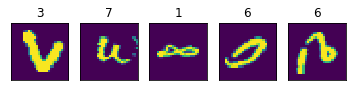

In [119]:
error_mask = y_pred != y_test
plot_example(x_test[error_mask], y_pred[error_mask])

In [127]:
rscv.best_estimator_

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (dropout): Dropout(p=0, inplace=False)
    (fc1): Linear(in_features=784, out_features=249, bias=True)
    (fc2): Linear(in_features=249, out_features=12, bias=True)
    (fc3): Linear(in_features=12, out_features=10, bias=True)
  ),
)

In [0]:
wfc1=rscv.best_estimator_.module_.fc1.weight.data.cpu().numpy()
wfc2=rscv.best_estimator_.module_.fc2.weight.data.cpu().numpy()
wfc3=rscv.best_estimator_.module_.fc3.weight.data.cpu().numpy()


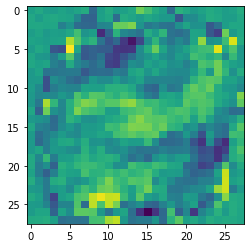

In [161]:
plt.imshow(wfc1[0].reshape(28,28) )


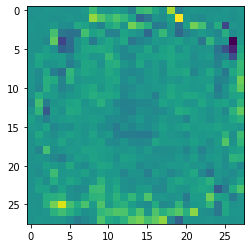

In [149]:
plt.imshow(np.matmul(wfc2[0], wfc1).reshape(28,28))

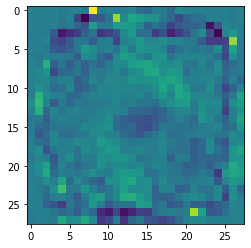

In [150]:
plt.imshow(np.matmul(wfc3[0], np.matmul(wfc2, wfc1)).reshape(28,28))

In [0]:
rscv.best_estimator_.save_params(f_params='pesi.pkl')


In [0]:
new_net = NeuralNetClassifier(
    module=Net,
    module__Ni=784,
    module__Nh1=249,
    module__Nh2=12,
    module__No=10,
    module__dropout=0
)

new_net.initialize() # This is important!
new_net.load_params(f_params='pesi.pkl')

In [173]:
y_pred_new = new_net.predict(x_test)
accuracy_score(y_test, y_pred_new)

0.9687